# DSC350 - Week 7 - Exercise 7.2

We begin the exercises this week by importing the necessary libraries and files.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib import cm
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

fb = pd.read_csv(r'C:\Users\thefli0\Downloads\fb_stock_prices_2018 (1).csv', index_col='date', parse_dates=True)
quakes = pd.read_csv(r'C:\Users\thefli0\Downloads\earthquakes (2).csv')
covid = pd.read_csv(r'C:\Users\thefli0\Downloads\covid19_cases.csv').assign(
    date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
).set_index('date').replace(
    'United_States_of_America', 'USA'
).sort_index()['2020-01-18':'2020-09-18']

## Hands-On Data Analysis with Python (2nd Edition): Page 388, Exercise 1-6

**1. Using seaborn, create a heatmap to visualize the correlation coefficients between earthquake magnitude and whether there was a tsunami for earthquakes measured with the "mb" magnitude type.**

Text(0.5, 1.01, 'Correlation Between Earthquake Magnitude\nand Tsunami Presence')

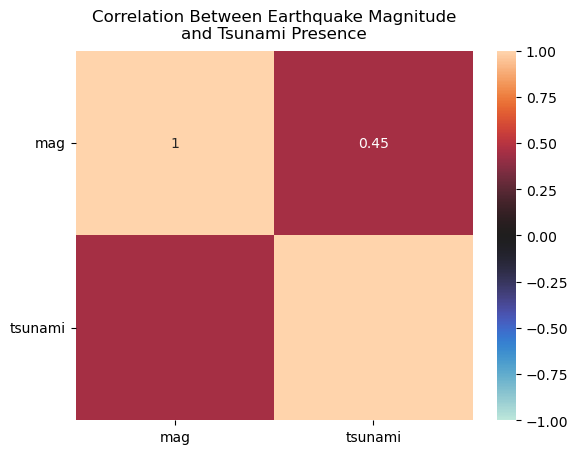

In [2]:
# Define parameters for the heatmap
sns.heatmap(
    quakes.query('magType == "mb"')[['mag','tsunami']].corr(), 
    annot=True, center=0, vmin=-1, vmax=1
)
# Customize labels for visualization
plt.yticks(rotation=0)
plt.title('Correlation Between Earthquake Magnitude\nand Tsunami Presence', y=1.01)

**2. Create a box plot of Facebook volume traded and closing prices, and draw reference lines for the bounds of a Tukey fence with a multiplier of 1.5. The bounds will be at $Q_{1} - 1.5 \times IQR$ and $Q_{3} + 1.5 \times IQR$. Be sure to use the quantile() method on the data to make this easier. (Pick whichever orientation you prefer for the plot, but make sure to use subplots.)**

Text(0.5, 1.1, 'Volume Traded and Closing Price with Tukey Fence Bounds for Facebook Stock (2018)')

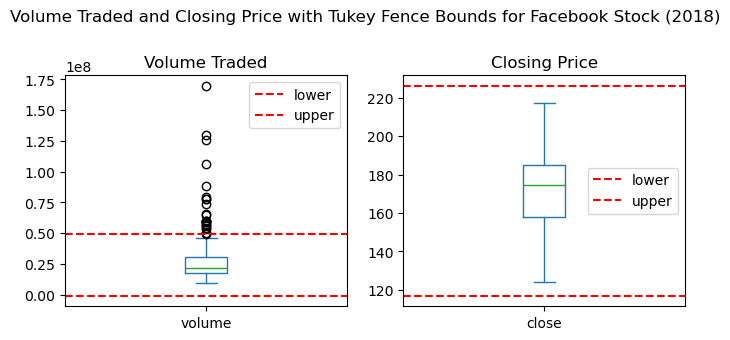

In [3]:
# Define the box plots and subsets
cols = ['volume', 'close']
subset = fb[cols]

# Define the first and third quantiles
quantiles = subset.quantile([0.25, 0.75])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]

# Customize the plot labels
axes = subset.plot(kind='box', subplots=True, figsize=(8, 3), title=['Volume Traded', 'Closing Price'])
for ax, col in zip(axes, cols):
    stats = quantiles[col]
    # Define the bounds for the interquartile ranges
    lower = stats.loc[0.25] - 1.5 * stats['iqr']
    upper = stats.loc[0.75] + 1.5 * stats['iqr']
    for bound, name in zip([lower, upper], ['lower', 'upper']):
        ax.axhline(
            bound, 
            color='red', 
            linestyle='dashed',
            label=name
        )
        ax.legend()
plt.suptitle('Volume Traded and Closing Price with Tukey Fence Bounds for Facebook Stock (2018)', y=1.1)

**3. Plot the evolution of cumulative COVID-19 cases worldwide, and add a dashed vertical line on the date that it surpassed 1 million. Be sure to format the tick labels on the y-axis accordingly.**

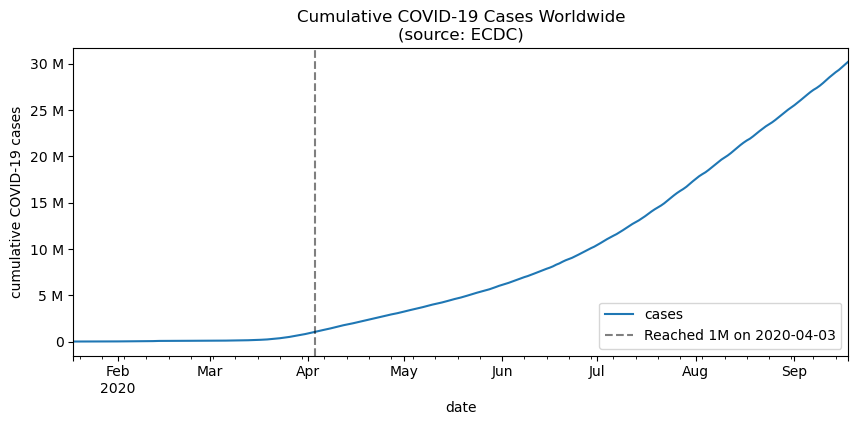

In [4]:
# Define calculation to aggregate cases
cumulative_cases = covid.groupby(pd.Grouper(freq='1D')).sum().cases.cumsum()

# Specify appropriate labels with ticks
ax = cumulative_cases.plot(title='Cumulative COVID-19 Cases Worldwide\n(source: ECDC)', figsize=(10, 4))
ax.set_ylabel('cumulative COVID-19 cases')
ax.yaxis.set_major_formatter(EngFormatter())

# Specify addition of dashed vertical line when 1 million surpassed
over_1M = cumulative_cases[cumulative_cases >= 1e6].index[0]
ax.axvline(over_1M, linestyle='dashed', color='k', alpha=0.5, label=f"Reached 1M on {over_1M.strftime('%Y-%m-%d')}")

# Show legend
ax.legend()

**4. Use axvspan() to shad a rectangle from '2018-07-25' to '2018-07-31', which marks the large decline in Facebook price on a line plot of the closing price.**

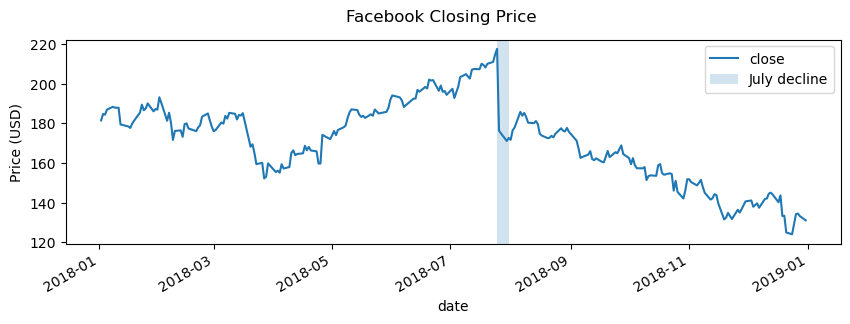

In [5]:
# Define function to configure visualization
fb.close.plot(kind='line', figsize=(10, 3))
# Use axvspan() function for shading
plt.axvspan(
    '2018-07-25', '2018-07-31', alpha=0.2, label='July decline',
)
# Specify appropriate labels
plt.ylabel('Price (USD)')
plt.suptitle('Facebook Closing Price')
plt.legend()

**5. Using the Facebook stock price data, annotate the following three events on a line plot of the closing price:**
 - a) "Disappointing user growth announced after close" on July 25, 2018
 - b) "Cambridge Analytica story breaks" on March 19, 2018 (when it affected the market)
 - c) "FTC launches investigation" on March 20, 2018

Text(0.5, 0.98, 'Facebook Closing Price')

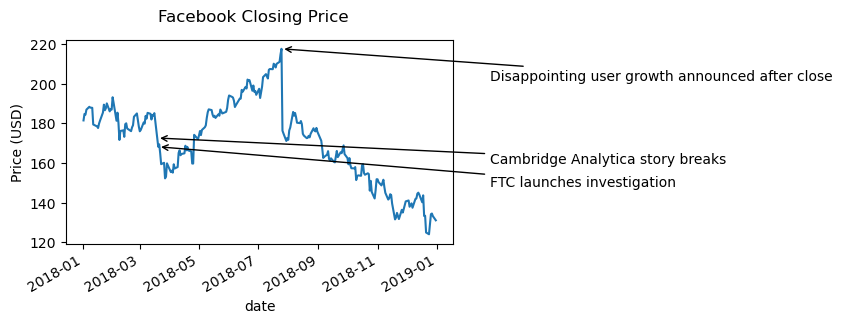

In [6]:
# Define function to configure visualization
fb.close.plot(kind='line', figsize=(5, 3))

# Specify notes for the events
notes = [
    ('Disappointing user growth announced after close', '2018-07-25'),
    ('Cambridge Analytica story breaks', '2018-03-19'),
    ('FTC launches investigation', '2018-03-20')
]

# Define function for repeatable random jitter
np.random.seed(1)

for text, date in notes:
    y_value = fb.close[date]
    jitter = np.random.uniform(-20, -10, 1)
    plt.annotate(
        text, 
        xy=(date, y_value),
        xytext=('2019-02-25', y_value + jitter),
        arrowprops=dict(arrowstyle='->')
    )
# Specify labels appropriately
plt.ylabel('Price (USD)')
plt.suptitle('Facebook Closing Price')

**6. Modify the reg_resid_plots() function to use a matplotlib colormap instead of cycling between two colors. Remember, for this use case, we should pick a qualitative colormap or make our own.**

In [7]:
# Define parameters of the reg_resid_plots() function
def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals
    plots side-by-side for every permutation of 2 columns 
    in the data.

    Parameters:
        - data: A `pandas.DataFrame` object

    Returns:
        A matplotlib `Axes` object.
    """
    # Define calculation for residuals
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    # Configure visualization
    fig, ax = plt.subplots(
        permutation_count, 
        2, 
        figsize=(15, 4 * permutation_count)
    )

    # Create iteration for efficient looping
    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        [cm.Dark2(i) for i in range(len(ax))]
    ):
        # Configure labels appropriately
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)

            # Define function for labeling subplot
            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')

    return fig.axes

6a. Use the function that was created to complete the result and display to the user.

[<Axes: xlabel='close', ylabel='volume'>,
 <Axes: xlabel='close', ylabel='residuals'>,
 <Axes: xlabel='volume', ylabel='close'>,
 <Axes: xlabel='volume', ylabel='residuals'>]

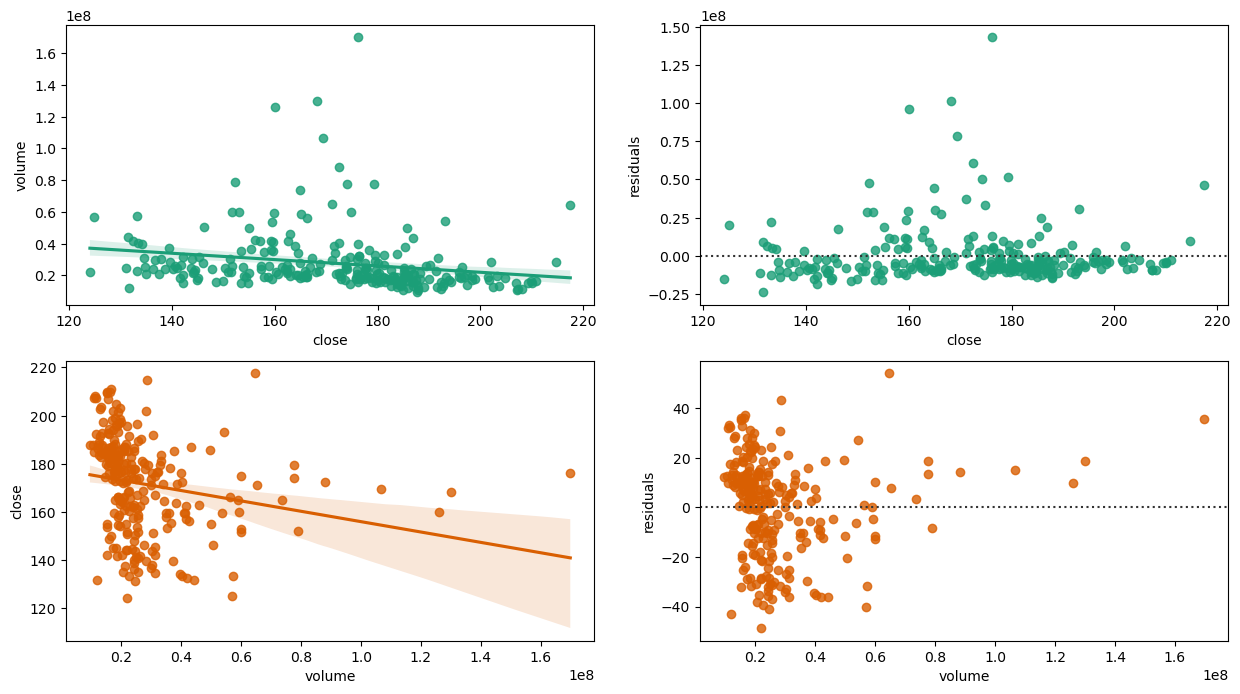

In [8]:
# Use the newly defined function to return results
reg_resid_plots(fb[['close', 'volume']])